# Pacotes

In [131]:
import pandas as pd
import glob
import os

from scipy.stats import zscore
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

# import keras
# from keras.models import Sequential # Create Model
# from keras.layers import Dense # Neurons
# from keras.layers import LSTM # Long Short Term Memory
# from sklearn.preprocessing import MinMaxScaler # Normalize
# from sklearn.metrics import mean_squared_error # Loss Function
# from sklearn.model_selection import train_test_split

# <font color='red'> 1)  Coleta dos dados</font>

### 1.1) Leitura dos arquivos

#### OBS: Escolhi utilizar os arquivos csv pela facilidade de leitura e poder utilizar chunks de dados

In [155]:
def get_csv_files(years: range = range(2000, 2021), directory: str = "../data") -> list: 
    dataframes_list = []

    for year in years:
        file_name = f"GERACAO_USINA_{year}.csv"
        file_path = os.path.join(directory, file_name)

        print(f"\nLendo o arquivo {file_name}...")

        if glob.glob(file_path):
            df = pd.read_csv(file_path, delimiter=";", encoding="utf-8", low_memory=False)

            df['din_instante'] = pd.to_datetime(df['din_instante'])

            dataframes_list.append(df)
        else:
            raise Exception(f"O arquivo {file_name} não foi encontrado.")
            

    return dataframes_list

In [156]:
try: 
    dataframes = get_csv_files(range(2000, 2003), "../data")
except Exception as e:
    print(f"Erro: {e}")


Lendo o arquivo GERACAO_USINA_2000.csv...

Lendo o arquivo GERACAO_USINA_2001.csv...

Lendo o arquivo GERACAO_USINA_2002.csv...


### 1.2) Observando dados crus

In [157]:
display(dataframes[0].head(10))

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao
0,2000-01-01,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.5
1,2000-01-01,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.6
2,2000-01-01,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.0
3,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.5
4,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.8
5,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Sobradinho,UHE.PH.BA.002755-3.01,322.8
6,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso IV,UHE.PH.BA.027050-4.01,779.4
7,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso I,UHE.PH.BA.002012-5.01,119.4
8,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso III,UHE.PH.BA.027049-0.01,480.4
9,2000-01-01,NE,NORDESTE,BA,BAHIA,TIPO I,TÉRMICA,Gás,Camaçari,UTE.GN.BA.000602-5.01,0.0


In [135]:
dataframes[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993556 entries, 0 to 993555
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   din_instante            993556 non-null  datetime64[ns]
 1   id_subsistema           993556 non-null  object        
 2   nom_subsistema          993556 non-null  object        
 3   id_estado               993556 non-null  object        
 4   nom_estado              993556 non-null  object        
 5   cod_modalidadeoperacao  993556 non-null  object        
 6   nom_tipousina           993556 non-null  object        
 7   nom_tipocombustivel     993556 non-null  object        
 8   nom_usina               993556 non-null  object        
 9   ceg                     993556 non-null  object        
 10  val_geracao             993555 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 83.4+ MB


In [136]:
dataframes[0].shape

(993556, 11)

# <font color='red'> 2) Preparação inicial dos dados</font>

### 2.1) Seleção dos dados

#### 2.1.1) Selecionando apenas alguns atributos 

#### OBS: Agrupei os dados para a região sudeste e com foco na produção de energia por meio de hidrelétricas

In [158]:
def select_data(dataframes: list[pd.DataFrame], cols: list) -> list[pd.DataFrame]:
    output = []
    for df in dataframes: 
        df['din_instante'] = pd.to_datetime(df['din_instante'])

        # Agrupa os dados para o sudeste e hidroelétricas
        subset = df[(df['id_subsistema'] == 'SE') & (df['nom_tipousina'] == 'HIDROELÉTRICA')]

        # Deixa apenas as colunas desejadas
        subset = subset[cols]

        output.append(subset)

    return output

#### 2.1.2) Removendo estados que estão como sudeste (Mas não fazem parte do sudeste)

In [159]:
def remove_states_from_sudeste(dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    output = []
    states = ['ES', 'MG', 'RJ', 'SP']
    for df in dataframes:
        # Filtra os dados para o sudeste e hidroelétricas
        subset = df[df['id_estado'].isin(states)]

        output.append(subset)

    return output

In [160]:
def groupby_hour(dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    output = []
    for df in dataframes:
        df_agrupado = df.groupby('din_instante')['val_geracao'].sum().reset_index()
        output.append(df_agrupado)

    return output

In [161]:
def groupby_day():
    print("groupby_day")

In [162]:
def groupby_month():
    print("groupby_month")

In [142]:
def groupby_year():
    print("groupby_year")

In [186]:
cols = ["din_instante", "id_estado", "nom_tipousina", "val_geracao"]

output_data = select_data(dataframes, cols)

output_data = remove_states_from_sudeste(output_data)

output_data[0].head(10)

,din_instante,id_estado,nom_tipousina,val_geracao
36,2000-01-01,ES,HIDROELÉTRICA,NaN
37,2000-01-01,ES,HIDROELÉTRICA,13.0
43,2000-01-01,MG,HIDROELÉTRICA,924.3
44,2000-01-01,MG,HIDROELÉTRICA,97.2
45,2000-01-01,MG,HIDROELÉTRICA,23.4
46,2000-01-01,MG,HIDROELÉTRICA,29.3
47,2000-01-01,MG,HIDROELÉTRICA,244.5
48,2000-01-01,MG,HIDROELÉTRICA,120.0
49,2000-01-01,MG,HIDROELÉTRICA,75.0
50,2000-01-01,MG,HIDROELÉTRICA,139.6


In [144]:
output_data[0].info()

<class 'pandas.core.frame.DataFrame'>
Index: 500631 entries, 36 to 993553
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   din_instante   500631 non-null  datetime64[ns]
 1   id_estado      500631 non-null  object        
 2   nom_tipousina  500631 non-null  object        
 3   val_geracao    500630 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 19.1+ MB


### 2.2) Limpeza dos dados 

#### 2.2.1) Corrigindo de dados ausentes (se houver)

In [164]:
def plot_missing_data(dataframes: list[pd.DataFrame]) -> None:
    combined_df = pd.concat(dataframes)

    # Verifica a quantidade de dados ausentes para a coluna 'val_geracao'
    plt.figure(figsize=(8, 6))
    msno.matrix(combined_df[['val_geracao']])
    plt.title('Matriz de Dados Ausentes para a Coluna "val_geracao"')
    plt.show()

In [165]:
def missing_data_correction(dataframes: list[pd.DataFrame]) -> list[pd.DataFrame]:
    output = []
    for df in dataframes:
        daily_means = df.groupby(df['din_instante'].dt.dayofyear)['val_geracao'].mean()

        df['val_geracao'] = df.apply(
            lambda row: daily_means[row['din_instante'].dayofyear] if pd.isna(row['val_geracao']) else row['val_geracao'],
            axis=1
        )

        output.append(df)

    return output
    

<Figure size 800x600 with 0 Axes>

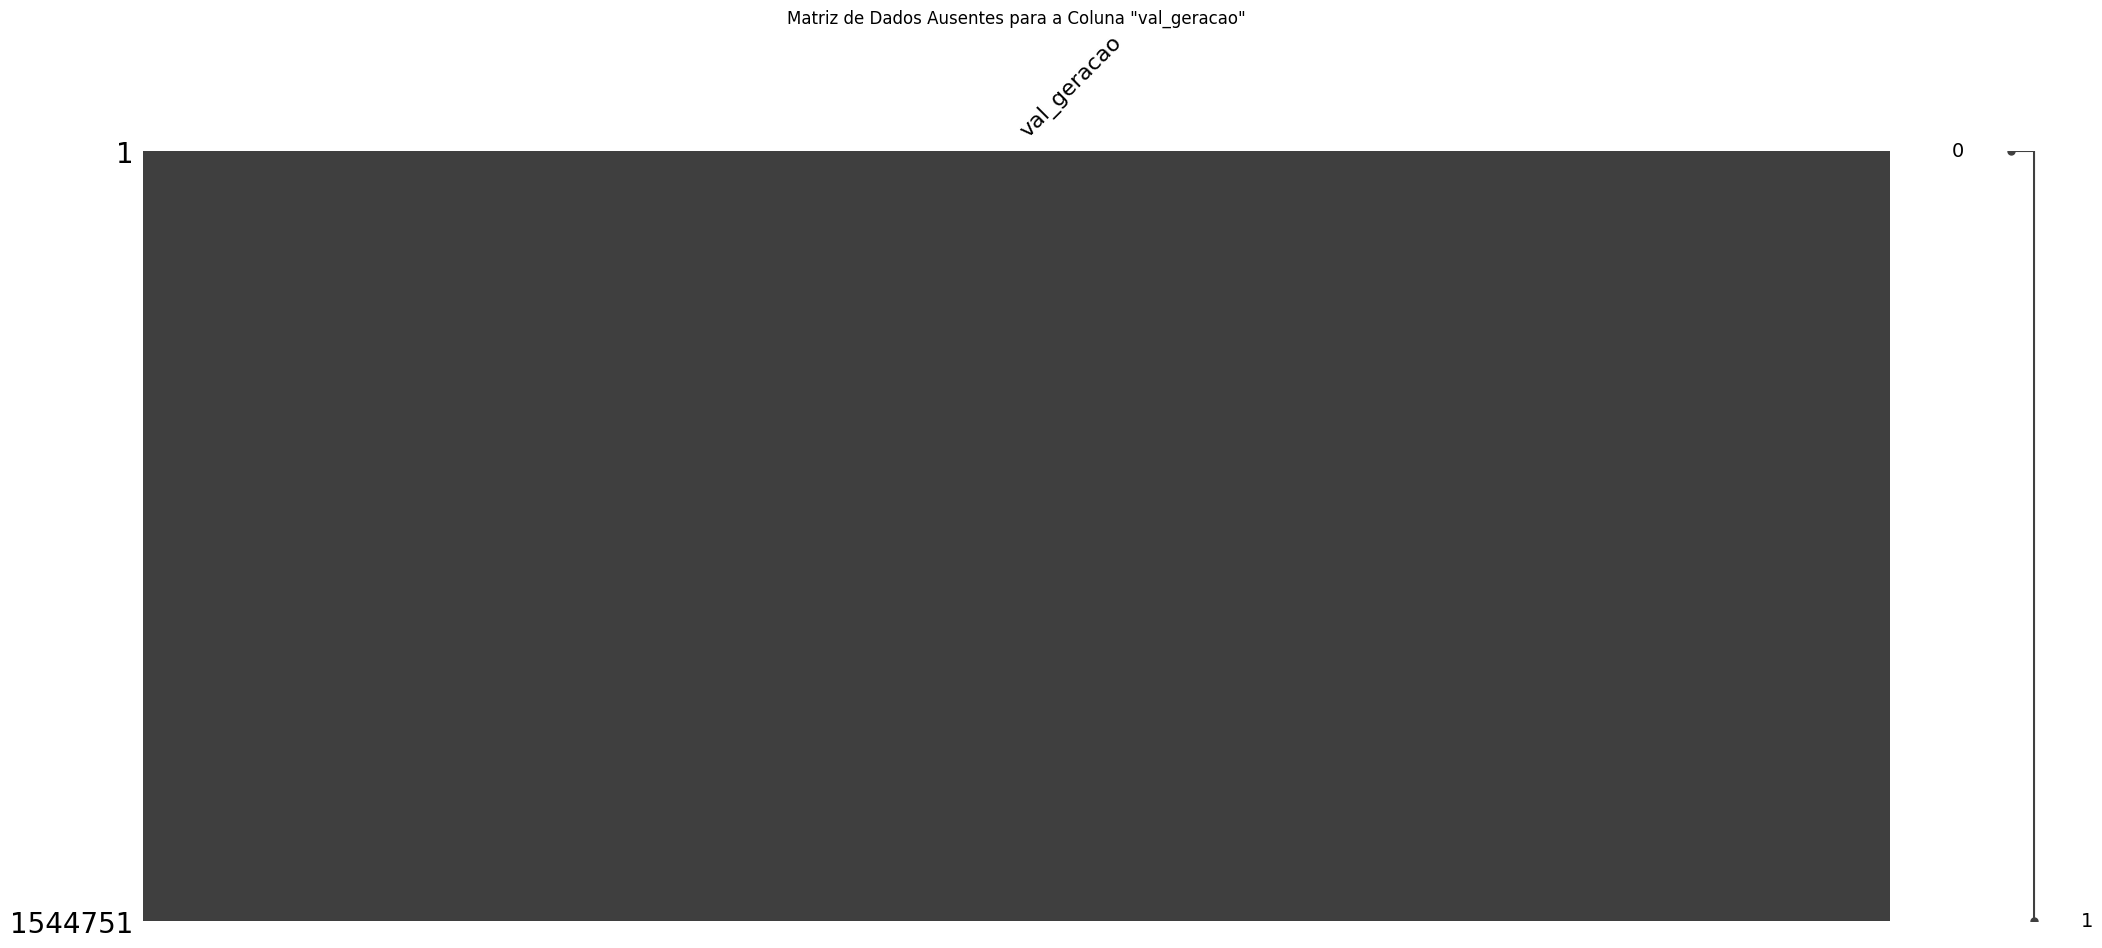

In [166]:
plot_missing_data(output_data)

In [167]:
output_data = missing_data_correction(output_data)

#### 2.2.2) Corrigindo de dados outliers (se houver)

In [182]:
def plot_outliers_data(dataframes: list[pd.DataFrame]) -> None:
    for df in dataframes:
        # Agrupo os dados por dia e calculo a média dos valores de 'val_geracao'
        df_diario = df.groupby(df['din_instante'].dt.date)['val_geracao'].mean().reset_index()

        plt.figure(figsize=(12, 6))
        sns.lineplot(x='din_instante', y='val_geracao', data=df_diario, errorbar=None)
        plt.title('Valores de Geração por Dia (Média Diária)')
        plt.xlabel('Data')
        plt.ylabel('Média Diária de Valores de Geração')
        plt.show()

    # for df in dataframes:
        # plt.figure(figsize=(10, 6))
        # sns.boxplot(x='val_geracao', data=df)
        # plt.title('Boxplot da Coluna "val_geracao"')
        # plt.show()

In [187]:
def outliers_correction(dataframes: list[pd.DataFrame]) -> None:
    output = []

    for df in dataframes: 
        daily_means = df.groupby(df['din_instante'].dt.dayofyear)['val_geracao'].mean()
        # Passo 3: Identificar outliers usando z-score
        df['z_score'] = df.groupby(df['din_instante'].dt.dayofyear)['val_geracao'].transform(lambda x: zscore(x))
        outliers_mask = (df['z_score'].abs() > 3)  # Ajuste o limite conforme necessário

        # Passo 4: Substituir outliers pela média correspondente
        df.loc[outliers_mask, 'val_geracao'] = df.loc[outliers_mask, 'din_instante'].dt.dayofyear.map(daily_means)

        # Remover a coluna temporária 'z_score'
        df = df.drop(columns=['z_score'])

        output.append(df)
    
    return output

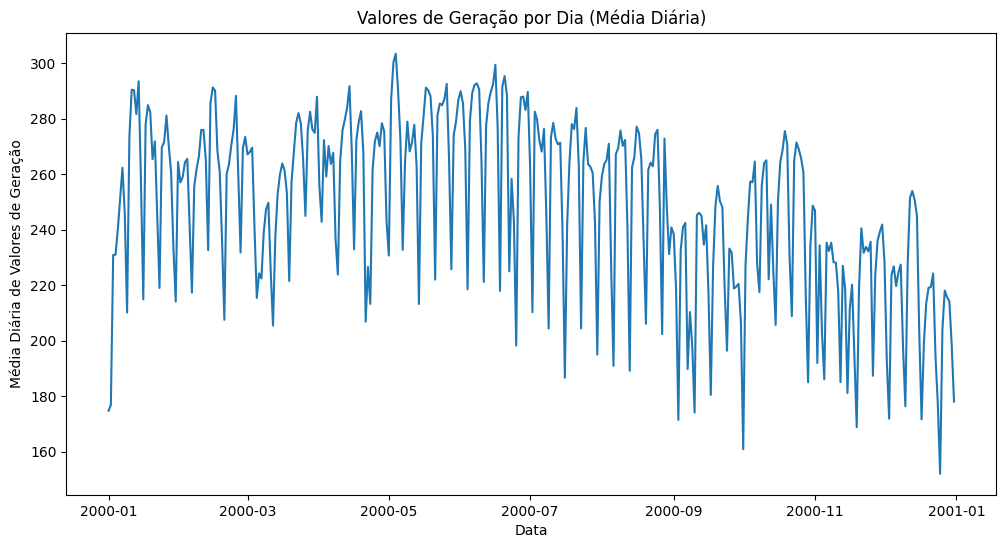

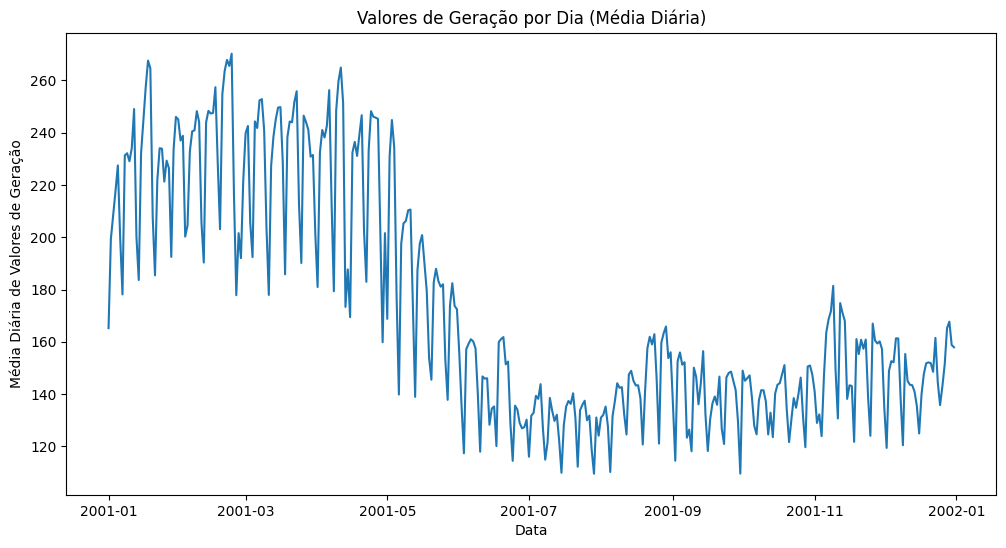

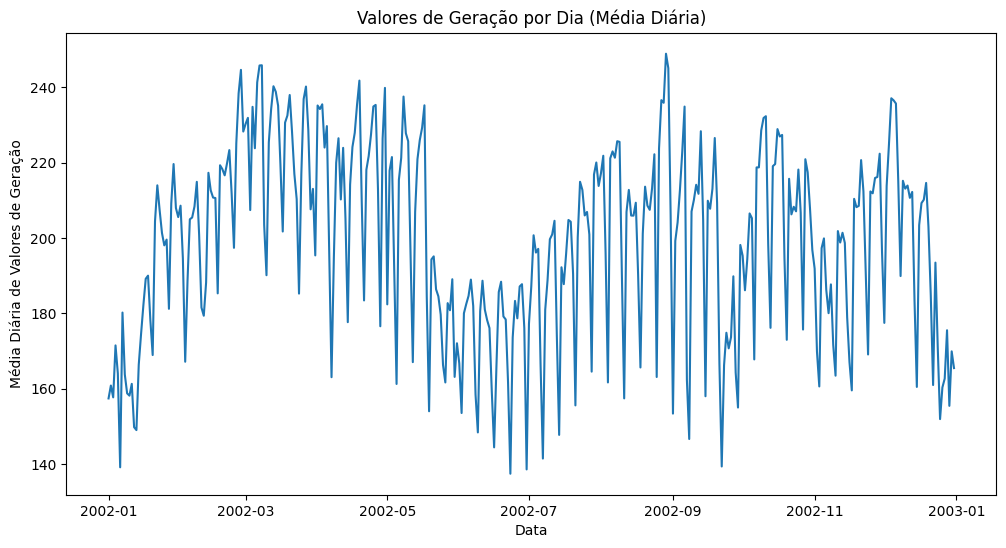

In [188]:
plot_outliers_data(output_data)

In [189]:
output_data = outliers_correction(output_data)

# <font color='red'> 3) Analise estatística</font>

# <font color='red'> 4) Pré-processamento dos dados</font>

# <font color='red'> 5) Modelo de predição</font>

### 5.1) Divisão dos dados

### 5.2) Arquitetando rede LTMS

# <font color='red'> 6) Avaliação do modelo</font>